In [0]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from keras.layers import AveragePooling2D, Activation, Lambda, Add
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.datasets import cifar10
from keras.utils import to_categorical
import keras.backend as K

from utils import plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features
from oct_conv2d import OctConv2D

Using TensorFlow backend.


# Parameters

In [2]:
STD_SIZE = (32, 32)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# Data preparation

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

x_train = x_train / 255
x_test = x_test / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE)

# Baseline

## Model

In [4]:
inputs = Input(shape=(32, 32, 3))
y = Conv2D(48, (3, 3), activation='relu', padding='same')(inputs)
y = Conv2D(48, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(96, (3, 3), activation='relu', padding='same')(y)
y = Conv2D(96, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(192, (3, 3), activation='relu', padding='same')(y)
y = Conv2D(192, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Dropout(0.25)(y)

y = Flatten()(y)
y = Dense(512, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
outputs = Dense(10, activation='softmax')(y)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

W0713 13:00:00.287600  6632 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 13:00:00.304600  6632 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 13:00:00.307601  6632 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 13:00:00.327602  6632 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0713 13:00:00.368604  6632 depreca

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        41568     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 96)          0         
__________

In [6]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=200, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + '9_layers_cifar_alpha_0', monitor='val_acc', save_best_only=True, verbose=1)
              ])

with open(PATH + '9_layers_cifar_alpha_0_history', 'wb') as f:
    pickle.dump(history.history, f)

W0713 13:00:00.549614  6632 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
 - 77s - loss: 1.9681 - acc: 0.2564 - val_loss: 1.7358 - val_acc: 0.3528

Epoch 00001: val_acc improved from -inf to 0.35280, saving model to 9_layers_cifar_alpha_0
Epoch 2/200
 - 62s - loss: 1.6994 - acc: 0.3703 - val_loss: 1.5435 - val_acc: 0.4431

Epoch 00002: val_acc improved from 0.35280 to 0.44310, saving model to 9_layers_cifar_alpha_0
Epoch 3/200
 - 62s - loss: 1.5528 - acc: 0.4370 - val_loss: 1.4066 - val_acc: 0.5016

Epoch 00003: val_acc improved from 0.44310 to 0.50160, saving model to 9_layers_cifar_alpha_0
Epoch 4/200
 - 62s - loss: 1.4356 - acc: 0.4827 - val_loss: 1.2396 - val_acc: 0.5551

Epoch 00004: val_acc improved from 0.50160 to 0.55510, saving model to 9_layers_cifar_alpha_0
Epoch 5/200
 - 62s - loss: 1.3575 - acc: 0.5178 - val_loss: 1.1714 - val_acc: 0.5772

Epoch 00005: val_acc improved from 0.55510 to 0.57720, saving model to 9_layers_cifar_alpha_0
Epoch 6/200
 - 62s - loss: 1.2956 - acc: 0.5430 - val_loss: 1.2304 - val_acc: 0.5919

Epoch 00006: val_

 - 62s - loss: 1.9384 - acc: 0.3033 - val_loss: 1.6398 - val_acc: 0.4020

Epoch 00058: val_acc did not improve from 0.68580
Epoch 59/200
 - 62s - loss: 1.9423 - acc: 0.2995 - val_loss: 1.9818 - val_acc: 0.4033

Epoch 00059: val_acc did not improve from 0.68580
Epoch 60/200
 - 62s - loss: 1.9526 - acc: 0.2940 - val_loss: 1.6701 - val_acc: 0.3960

Epoch 00060: val_acc did not improve from 0.68580
Epoch 61/200
 - 62s - loss: 1.9462 - acc: 0.2887 - val_loss: 2.8713 - val_acc: 0.3203

Epoch 00061: val_acc did not improve from 0.68580
Epoch 62/200
 - 62s - loss: 1.9686 - acc: 0.2877 - val_loss: 1.6617 - val_acc: 0.4015

Epoch 00062: val_acc did not improve from 0.68580
Epoch 63/200
 - 62s - loss: 1.9704 - acc: 0.2900 - val_loss: 1.6796 - val_acc: 0.4251

Epoch 00063: val_acc did not improve from 0.68580
Epoch 64/200
 - 62s - loss: 1.9765 - acc: 0.2843 - val_loss: 1.6330 - val_acc: 0.4145

Epoch 00064: val_acc did not improve from 0.68580
Epoch 65/200
 - 62s - loss: 1.9906 - acc: 0.2840 - val

 - 61s - loss: 2.0535 - acc: 0.2530 - val_loss: 1.9588 - val_acc: 0.2501

Epoch 00118: val_acc did not improve from 0.68580
Epoch 119/200
 - 61s - loss: 2.0773 - acc: 0.2497 - val_loss: 1.7480 - val_acc: 0.3591

Epoch 00119: val_acc did not improve from 0.68580
Epoch 120/200
 - 61s - loss: 2.0919 - acc: 0.2502 - val_loss: 1.8367 - val_acc: 0.3124

Epoch 00120: val_acc did not improve from 0.68580
Epoch 121/200
 - 61s - loss: 2.1323 - acc: 0.2424 - val_loss: 1.9591 - val_acc: 0.3030

Epoch 00121: val_acc did not improve from 0.68580
Epoch 122/200
 - 61s - loss: 2.0599 - acc: 0.2504 - val_loss: 2.0620 - val_acc: 0.2736

Epoch 00122: val_acc did not improve from 0.68580
Epoch 123/200
 - 61s - loss: 4.1196 - acc: 0.2175 - val_loss: 2.4694 - val_acc: 0.3210

Epoch 00123: val_acc did not improve from 0.68580
Epoch 124/200
 - 61s - loss: 2.0862 - acc: 0.2383 - val_loss: 1.9764 - val_acc: 0.2543

Epoch 00124: val_acc did not improve from 0.68580
Epoch 125/200
 - 61s - loss: 2.0769 - acc: 0.234


Epoch 00177: val_acc did not improve from 0.68580
Epoch 178/200
 - 62s - loss: 14.5069 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000

Epoch 00178: val_acc did not improve from 0.68580
Epoch 179/200
 - 62s - loss: 14.5065 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000

Epoch 00179: val_acc did not improve from 0.68580
Epoch 180/200
 - 62s - loss: 14.5050 - acc: 0.1001 - val_loss: 14.5063 - val_acc: 0.1000

Epoch 00180: val_acc did not improve from 0.68580
Epoch 181/200
 - 61s - loss: 14.5031 - acc: 0.1002 - val_loss: 14.5063 - val_acc: 0.1000

Epoch 00181: val_acc did not improve from 0.68580
Epoch 182/200
 - 62s - loss: 14.5056 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000

Epoch 00182: val_acc did not improve from 0.68580
Epoch 183/200
 - 62s - loss: 14.5035 - acc: 0.1002 - val_loss: 14.5015 - val_acc: 0.1003

Epoch 00183: val_acc did not improve from 0.68580
Epoch 184/200
 - 62s - loss: 10.2322 - acc: 0.1268 - val_loss: 3.6212 - val_acc: 0.1929

Epoch 00184: val_acc

## Results

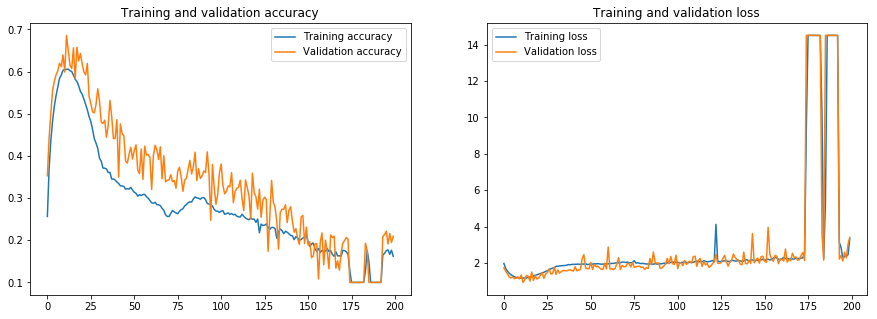

In [7]:
plot_accuracy_and_loss(history)

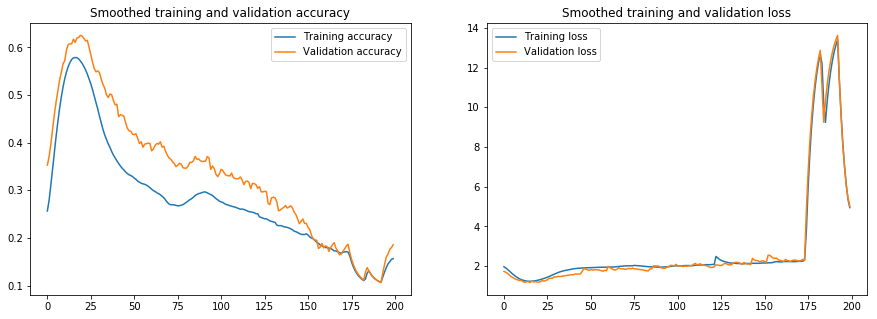

In [8]:
plot_smoothed_acc_and_loss(history, 0.8)

In [9]:
model = load_model(PATH + '9_layers_cifar_alpha_0')
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 303us/step


[0.9268458698272705, 0.6858]

# OctConv

In [10]:
for alpha in [0.125, 0.25, 0.5, 0.75]:
    inputs = Input(shape=(32, 32, 3))
    low = AveragePooling2D(2)(inputs)
    
    high, low = OctConv2D(filters=48, alpha=alpha)([inputs, low])
    high, low = Activation('relu')(high), Activation('relu')(low)  
    high, low = OctConv2D(filters=48, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=96, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=96, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=192, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high = Conv2D(192, 3, padding='same')(high)
    low = Conv2D(192, 3, padding='same')(low)
    low = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(low)
    x = Add()([high, low])
    x = Activation('relu')(x)
    
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=1e-4),
                  metrics=['accuracy'])
    history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=200, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + f'9_layers_cifar_alpha_{alpha}', monitor='val_acc', save_best_only=True, verbose=1)
              ])

    with open(PATH + f'9_layers_cifar_alpha_{alpha}_history', 'wb') as f:
        pickle.dump(history.history, f)

W0713 16:25:28.991251  6632 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



Epoch 1/200
 - 94s - loss: 1.9829 - acc: 0.2602 - val_loss: 1.6769 - val_acc: 0.3772

Epoch 00001: val_acc improved from -inf to 0.37720, saving model to 9_layers_cifar_alpha_0.125
Epoch 2/200
 - 92s - loss: 1.7276 - acc: 0.3680 - val_loss: 1.4536 - val_acc: 0.4677

Epoch 00002: val_acc improved from 0.37720 to 0.46770, saving model to 9_layers_cifar_alpha_0.125
Epoch 3/200
 - 92s - loss: 1.5942 - acc: 0.4247 - val_loss: 1.6018 - val_acc: 0.4418

Epoch 00003: val_acc did not improve from 0.46770
Epoch 4/200
 - 92s - loss: 1.5014 - acc: 0.4614 - val_loss: 1.3906 - val_acc: 0.5202

Epoch 00004: val_acc improved from 0.46770 to 0.52020, saving model to 9_layers_cifar_alpha_0.125
Epoch 5/200
 - 92s - loss: 1.4360 - acc: 0.4894 - val_loss: 1.2958 - val_acc: 0.5421

Epoch 00005: val_acc improved from 0.52020 to 0.54210, saving model to 9_layers_cifar_alpha_0.125
Epoch 6/200
 - 92s - loss: 1.3775 - acc: 0.5131 - val_loss: 1.2355 - val_acc: 0.5681

Epoch 00006: val_acc improved from 0.54210 to

 - 92s - loss: 1.9193 - acc: 0.3254 - val_loss: 1.6581 - val_acc: 0.4179

Epoch 00057: val_acc did not improve from 0.66460
Epoch 58/200
 - 92s - loss: 1.9312 - acc: 0.3255 - val_loss: 1.5437 - val_acc: 0.4621

Epoch 00058: val_acc did not improve from 0.66460
Epoch 59/200
 - 92s - loss: 1.9484 - acc: 0.3155 - val_loss: 1.6111 - val_acc: 0.4087

Epoch 00059: val_acc did not improve from 0.66460
Epoch 60/200
 - 92s - loss: 1.9341 - acc: 0.3180 - val_loss: 1.5100 - val_acc: 0.4208

Epoch 00060: val_acc did not improve from 0.66460
Epoch 61/200
 - 92s - loss: 1.9434 - acc: 0.3116 - val_loss: 1.6363 - val_acc: 0.4164

Epoch 00061: val_acc did not improve from 0.66460
Epoch 62/200
 - 92s - loss: 1.9726 - acc: 0.3069 - val_loss: 1.6522 - val_acc: 0.3752

Epoch 00062: val_acc did not improve from 0.66460
Epoch 63/200
 - 92s - loss: 1.9857 - acc: 0.3060 - val_loss: 1.6775 - val_acc: 0.4014

Epoch 00063: val_acc did not improve from 0.66460
Epoch 64/200
 - 92s - loss: 1.9950 - acc: 0.2979 - val

 - 92s - loss: 2.0748 - acc: 0.2557 - val_loss: 2.7222 - val_acc: 0.3324

Epoch 00117: val_acc did not improve from 0.66460
Epoch 118/200
 - 92s - loss: 2.1187 - acc: 0.2541 - val_loss: 1.8141 - val_acc: 0.3112

Epoch 00118: val_acc did not improve from 0.66460
Epoch 119/200
 - 92s - loss: 2.0660 - acc: 0.2530 - val_loss: 1.7588 - val_acc: 0.3198

Epoch 00119: val_acc did not improve from 0.66460
Epoch 120/200
 - 92s - loss: 2.0726 - acc: 0.2517 - val_loss: 1.9107 - val_acc: 0.3189

Epoch 00120: val_acc did not improve from 0.66460
Epoch 121/200
 - 92s - loss: 2.0930 - acc: 0.2552 - val_loss: 1.9021 - val_acc: 0.3030

Epoch 00121: val_acc did not improve from 0.66460
Epoch 122/200
 - 92s - loss: 2.1032 - acc: 0.2532 - val_loss: 1.7832 - val_acc: 0.3245

Epoch 00122: val_acc did not improve from 0.66460
Epoch 123/200
 - 92s - loss: 2.0899 - acc: 0.2528 - val_loss: 2.2255 - val_acc: 0.2826

Epoch 00123: val_acc did not improve from 0.66460
Epoch 124/200
 - 92s - loss: 2.1145 - acc: 0.245


Epoch 00176: val_acc did not improve from 0.66460
Epoch 177/200
 - 92s - loss: 14.5092 - acc: 0.0998 - val_loss: 14.5031 - val_acc: 0.1002

Epoch 00177: val_acc did not improve from 0.66460
Epoch 178/200
 - 92s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5031 - val_acc: 0.1002

Epoch 00178: val_acc did not improve from 0.66460
Epoch 179/200
 - 92s - loss: 14.5085 - acc: 0.0999 - val_loss: 14.5224 - val_acc: 0.0990

Epoch 00179: val_acc did not improve from 0.66460
Epoch 180/200
 - 92s - loss: 14.5066 - acc: 0.1000 - val_loss: 14.4950 - val_acc: 0.1007

Epoch 00180: val_acc did not improve from 0.66460
Epoch 181/200
 - 92s - loss: 14.5050 - acc: 0.1001 - val_loss: 14.5127 - val_acc: 0.0996

Epoch 00181: val_acc did not improve from 0.66460
Epoch 182/200
 - 92s - loss: 14.5084 - acc: 0.0999 - val_loss: 14.5143 - val_acc: 0.0995

Epoch 00182: val_acc did not improve from 0.66460
Epoch 183/200
 - 92s - loss: 14.5040 - acc: 0.1001 - val_loss: 14.5031 - val_acc: 0.1002

Epoch 00183: val_ac


Epoch 00033: val_acc did not improve from 0.63540
Epoch 34/200
 - 91s - loss: 1.6412 - acc: 0.4468 - val_loss: 1.4108 - val_acc: 0.4966

Epoch 00034: val_acc did not improve from 0.63540
Epoch 35/200
 - 91s - loss: 1.6544 - acc: 0.4398 - val_loss: 1.5571 - val_acc: 0.4639

Epoch 00035: val_acc did not improve from 0.63540
Epoch 36/200
 - 91s - loss: 1.6538 - acc: 0.4440 - val_loss: 1.8132 - val_acc: 0.4481

Epoch 00036: val_acc did not improve from 0.63540
Epoch 37/200
 - 91s - loss: 1.6838 - acc: 0.4322 - val_loss: 1.5818 - val_acc: 0.4512

Epoch 00037: val_acc did not improve from 0.63540
Epoch 38/200
 - 91s - loss: 1.6920 - acc: 0.4293 - val_loss: 1.3507 - val_acc: 0.5388

Epoch 00038: val_acc did not improve from 0.63540
Epoch 39/200
 - 91s - loss: 1.7209 - acc: 0.4208 - val_loss: 1.4122 - val_acc: 0.5418

Epoch 00039: val_acc did not improve from 0.63540
Epoch 40/200
 - 91s - loss: 1.7150 - acc: 0.4226 - val_loss: 1.4348 - val_acc: 0.5254

Epoch 00040: val_acc did not improve fro


Epoch 00093: val_acc did not improve from 0.63540
Epoch 94/200
 - 90s - loss: 2.0419 - acc: 0.2510 - val_loss: 1.7737 - val_acc: 0.3155

Epoch 00094: val_acc did not improve from 0.63540
Epoch 95/200
 - 90s - loss: 2.0855 - acc: 0.2510 - val_loss: 2.0567 - val_acc: 0.3517

Epoch 00095: val_acc did not improve from 0.63540
Epoch 96/200
 - 90s - loss: 2.0648 - acc: 0.2485 - val_loss: 1.9146 - val_acc: 0.3408

Epoch 00096: val_acc did not improve from 0.63540
Epoch 97/200
 - 90s - loss: 2.0779 - acc: 0.2417 - val_loss: 2.9406 - val_acc: 0.3048

Epoch 00097: val_acc did not improve from 0.63540
Epoch 98/200
 - 90s - loss: 2.0816 - acc: 0.2404 - val_loss: 2.2654 - val_acc: 0.2943

Epoch 00098: val_acc did not improve from 0.63540
Epoch 99/200
 - 90s - loss: 2.0886 - acc: 0.2363 - val_loss: 1.7336 - val_acc: 0.3371

Epoch 00099: val_acc did not improve from 0.63540
Epoch 100/200
 - 90s - loss: 2.1214 - acc: 0.2350 - val_loss: 1.7977 - val_acc: 0.3315

Epoch 00100: val_acc did not improve fr

 - 91s - loss: 2.2147 - acc: 0.1746 - val_loss: 2.0302 - val_acc: 0.2097

Epoch 00153: val_acc did not improve from 0.63540
Epoch 154/200
 - 91s - loss: 2.2463 - acc: 0.1804 - val_loss: 2.1624 - val_acc: 0.2090

Epoch 00154: val_acc did not improve from 0.63540
Epoch 155/200
 - 91s - loss: 2.3481 - acc: 0.1775 - val_loss: 2.0096 - val_acc: 0.2347

Epoch 00155: val_acc did not improve from 0.63540
Epoch 156/200
 - 91s - loss: 2.3293 - acc: 0.1831 - val_loss: 2.0243 - val_acc: 0.2128

Epoch 00156: val_acc did not improve from 0.63540
Epoch 157/200
 - 91s - loss: 2.3310 - acc: 0.1783 - val_loss: 2.2828 - val_acc: 0.2138

Epoch 00157: val_acc did not improve from 0.63540
Epoch 158/200
 - 91s - loss: 2.4210 - acc: 0.1813 - val_loss: 2.0574 - val_acc: 0.2039

Epoch 00158: val_acc did not improve from 0.63540
Epoch 159/200
 - 90s - loss: 2.2503 - acc: 0.1762 - val_loss: 2.1013 - val_acc: 0.1786

Epoch 00159: val_acc did not improve from 0.63540
Epoch 160/200
 - 91s - loss: 2.2328 - acc: 0.176


Epoch 00010: val_acc did not improve from 0.59950
Epoch 11/200
 - 83s - loss: 1.3546 - acc: 0.5326 - val_loss: 1.1526 - val_acc: 0.5874

Epoch 00011: val_acc did not improve from 0.59950
Epoch 12/200
 - 83s - loss: 1.3553 - acc: 0.5328 - val_loss: 1.1751 - val_acc: 0.6113

Epoch 00012: val_acc improved from 0.59950 to 0.61130, saving model to 9_layers_cifar_alpha_0.5
Epoch 13/200
 - 84s - loss: 1.3539 - acc: 0.5316 - val_loss: 1.2675 - val_acc: 0.5819

Epoch 00013: val_acc did not improve from 0.61130
Epoch 14/200
 - 83s - loss: 1.3550 - acc: 0.5330 - val_loss: 1.2187 - val_acc: 0.5824

Epoch 00014: val_acc did not improve from 0.61130
Epoch 15/200
 - 83s - loss: 1.3644 - acc: 0.5332 - val_loss: 1.1594 - val_acc: 0.5994

Epoch 00015: val_acc did not improve from 0.61130
Epoch 16/200
 - 83s - loss: 1.3654 - acc: 0.5365 - val_loss: 1.7439 - val_acc: 0.5448

Epoch 00016: val_acc did not improve from 0.61130
Epoch 17/200
 - 83s - loss: 1.3797 - acc: 0.5307 - val_loss: 1.1128 - val_acc: 0.

 - 83s - loss: 1.8001 - acc: 0.3905 - val_loss: 1.5973 - val_acc: 0.4920

Epoch 00070: val_acc did not improve from 0.61370
Epoch 71/200
 - 83s - loss: 1.8069 - acc: 0.3870 - val_loss: 1.5177 - val_acc: 0.4653

Epoch 00071: val_acc did not improve from 0.61370
Epoch 72/200
 - 83s - loss: 1.8058 - acc: 0.3851 - val_loss: 1.5288 - val_acc: 0.4772

Epoch 00072: val_acc did not improve from 0.61370
Epoch 73/200
 - 83s - loss: 1.8434 - acc: 0.3760 - val_loss: 1.5391 - val_acc: 0.4725

Epoch 00073: val_acc did not improve from 0.61370
Epoch 74/200
 - 84s - loss: 1.8568 - acc: 0.3718 - val_loss: 1.6532 - val_acc: 0.4976

Epoch 00074: val_acc did not improve from 0.61370
Epoch 75/200
 - 83s - loss: 1.8563 - acc: 0.3661 - val_loss: 1.4486 - val_acc: 0.5236

Epoch 00075: val_acc did not improve from 0.61370
Epoch 76/200
 - 83s - loss: 1.8653 - acc: 0.3639 - val_loss: 1.5284 - val_acc: 0.4823

Epoch 00076: val_acc did not improve from 0.61370
Epoch 77/200
 - 83s - loss: 1.8629 - acc: 0.3587 - val

 - 83s - loss: 2.2524 - acc: 0.2062 - val_loss: 1.8073 - val_acc: 0.2990

Epoch 00130: val_acc did not improve from 0.61370
Epoch 131/200
 - 83s - loss: 2.1774 - acc: 0.2102 - val_loss: 2.0035 - val_acc: 0.3223

Epoch 00131: val_acc did not improve from 0.61370
Epoch 132/200
 - 83s - loss: 2.1744 - acc: 0.2118 - val_loss: 1.8515 - val_acc: 0.2845

Epoch 00132: val_acc did not improve from 0.61370
Epoch 133/200
 - 83s - loss: 2.1688 - acc: 0.2069 - val_loss: 1.8126 - val_acc: 0.2899

Epoch 00133: val_acc did not improve from 0.61370
Epoch 134/200
 - 83s - loss: 2.1597 - acc: 0.2071 - val_loss: 1.8333 - val_acc: 0.2781

Epoch 00134: val_acc did not improve from 0.61370
Epoch 135/200
 - 83s - loss: 2.1793 - acc: 0.2103 - val_loss: 2.0171 - val_acc: 0.2893

Epoch 00135: val_acc did not improve from 0.61370
Epoch 136/200
 - 83s - loss: 2.1400 - acc: 0.2125 - val_loss: 2.2906 - val_acc: 0.2509

Epoch 00136: val_acc did not improve from 0.61370
Epoch 137/200
 - 83s - loss: 2.1496 - acc: 0.212


Epoch 00189: val_acc did not improve from 0.61370
Epoch 190/200
 - 83s - loss: 2.4526 - acc: 0.1737 - val_loss: 2.1740 - val_acc: 0.1394

Epoch 00190: val_acc did not improve from 0.61370
Epoch 191/200
 - 83s - loss: 2.5039 - acc: 0.1714 - val_loss: 5.0394 - val_acc: 0.2262

Epoch 00191: val_acc did not improve from 0.61370
Epoch 192/200
 - 83s - loss: 2.8155 - acc: 0.1706 - val_loss: 2.2064 - val_acc: 0.2266

Epoch 00192: val_acc did not improve from 0.61370
Epoch 193/200
 - 83s - loss: 2.8141 - acc: 0.1699 - val_loss: 2.0504 - val_acc: 0.2266

Epoch 00193: val_acc did not improve from 0.61370
Epoch 194/200
 - 84s - loss: 2.4768 - acc: 0.1717 - val_loss: 2.6729 - val_acc: 0.2470

Epoch 00194: val_acc did not improve from 0.61370
Epoch 195/200
 - 83s - loss: 2.5082 - acc: 0.1735 - val_loss: 5.1247 - val_acc: 0.2440

Epoch 00195: val_acc did not improve from 0.61370
Epoch 196/200
 - 83s - loss: 3.5194 - acc: 0.1669 - val_loss: 2.6468 - val_acc: 0.2436

Epoch 00196: val_acc did not impr

 - 81s - loss: 1.6212 - acc: 0.4540 - val_loss: 1.2990 - val_acc: 0.5559

Epoch 00046: val_acc did not improve from 0.63790
Epoch 47/200
 - 81s - loss: 1.6179 - acc: 0.4540 - val_loss: 1.4392 - val_acc: 0.5035

Epoch 00047: val_acc did not improve from 0.63790
Epoch 48/200
 - 81s - loss: 1.6206 - acc: 0.4552 - val_loss: 1.3216 - val_acc: 0.5376

Epoch 00048: val_acc did not improve from 0.63790
Epoch 49/200
 - 81s - loss: 1.6276 - acc: 0.4492 - val_loss: 1.7709 - val_acc: 0.5072

Epoch 00049: val_acc did not improve from 0.63790
Epoch 50/200
 - 81s - loss: 1.6566 - acc: 0.4385 - val_loss: 1.9462 - val_acc: 0.4819

Epoch 00050: val_acc did not improve from 0.63790
Epoch 51/200
 - 81s - loss: 1.6582 - acc: 0.4352 - val_loss: 1.3623 - val_acc: 0.5524

Epoch 00051: val_acc did not improve from 0.63790
Epoch 52/200
 - 81s - loss: 1.6547 - acc: 0.4361 - val_loss: 1.7722 - val_acc: 0.4744

Epoch 00052: val_acc did not improve from 0.63790
Epoch 53/200
 - 81s - loss: 1.6551 - acc: 0.4357 - val

 - 81s - loss: 2.1402 - acc: 0.2448 - val_loss: 1.7169 - val_acc: 0.3683

Epoch 00106: val_acc did not improve from 0.63790
Epoch 107/200
 - 81s - loss: 2.1135 - acc: 0.2566 - val_loss: 2.1129 - val_acc: 0.3063

Epoch 00107: val_acc did not improve from 0.63790
Epoch 108/200
 - 81s - loss: 2.1481 - acc: 0.2380 - val_loss: 1.8271 - val_acc: 0.3217

Epoch 00108: val_acc did not improve from 0.63790
Epoch 109/200
 - 81s - loss: 2.1179 - acc: 0.2385 - val_loss: 2.5361 - val_acc: 0.3672

Epoch 00109: val_acc did not improve from 0.63790
Epoch 110/200
 - 81s - loss: 2.1655 - acc: 0.2316 - val_loss: 1.7492 - val_acc: 0.3352

Epoch 00110: val_acc did not improve from 0.63790
Epoch 111/200
 - 81s - loss: 2.1484 - acc: 0.2379 - val_loss: 1.8323 - val_acc: 0.3386

Epoch 00111: val_acc did not improve from 0.63790
Epoch 112/200
 - 81s - loss: 2.1846 - acc: 0.2338 - val_loss: 1.7633 - val_acc: 0.3273

Epoch 00112: val_acc did not improve from 0.63790
Epoch 113/200
 - 81s - loss: 2.1418 - acc: 0.231


Epoch 00165: val_acc did not improve from 0.63790
Epoch 166/200
 - 81s - loss: 2.3549 - acc: 0.1825 - val_loss: 2.0497 - val_acc: 0.2332

Epoch 00166: val_acc did not improve from 0.63790
Epoch 167/200
 - 81s - loss: 2.2599 - acc: 0.1797 - val_loss: 2.0669 - val_acc: 0.1995

Epoch 00167: val_acc did not improve from 0.63790
Epoch 168/200
 - 81s - loss: 2.2179 - acc: 0.1768 - val_loss: 2.1555 - val_acc: 0.1789

Epoch 00168: val_acc did not improve from 0.63790
Epoch 169/200
 - 81s - loss: 2.1830 - acc: 0.1744 - val_loss: 2.0219 - val_acc: 0.2351

Epoch 00169: val_acc did not improve from 0.63790
Epoch 170/200
 - 81s - loss: 2.2174 - acc: 0.1816 - val_loss: 2.6461 - val_acc: 0.1970

Epoch 00170: val_acc did not improve from 0.63790
Epoch 171/200
 - 81s - loss: 2.2634 - acc: 0.1803 - val_loss: 2.0772 - val_acc: 0.1995

Epoch 00171: val_acc did not improve from 0.63790
Epoch 172/200
 - 81s - loss: 2.3009 - acc: 0.1798 - val_loss: 2.1684 - val_acc: 0.2439

Epoch 00172: val_acc did not impr

For alpha = 0:
 Max test accuracy = 0.6858



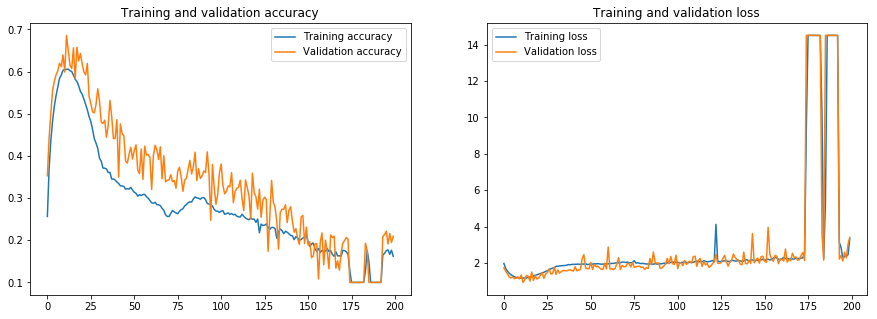

For alpha = 0.125:
 Max test accuracy = 0.6646



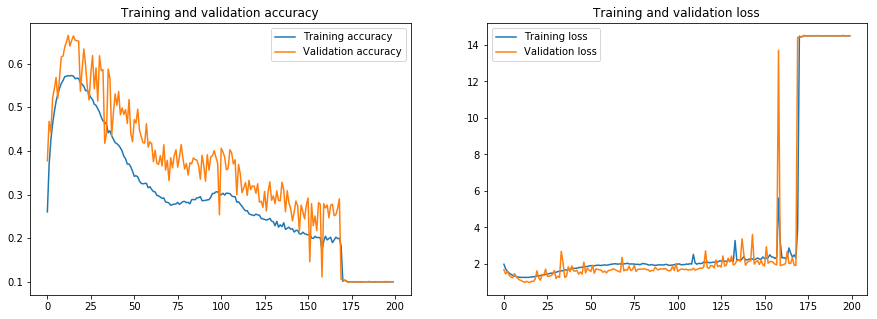

For alpha = 0.25:
 Max test accuracy = 0.6354



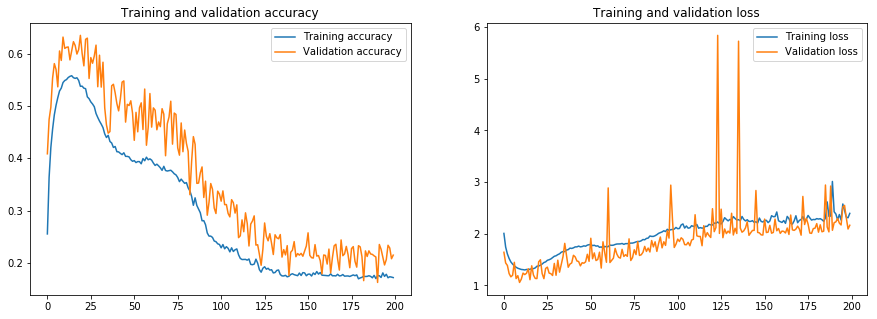

For alpha = 0.5:
 Max test accuracy = 0.6137



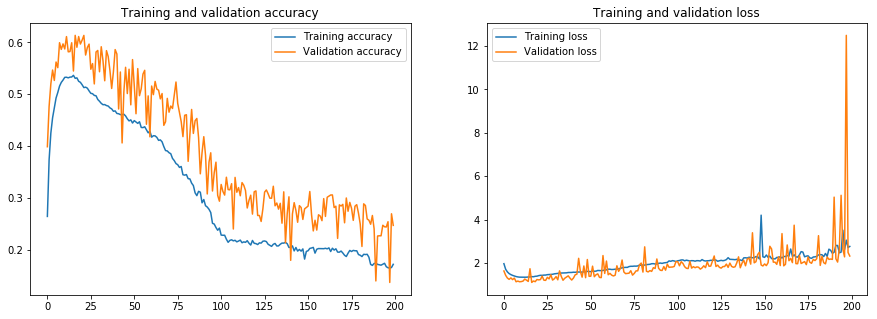

For alpha = 0.75:
 Max test accuracy = 0.6379



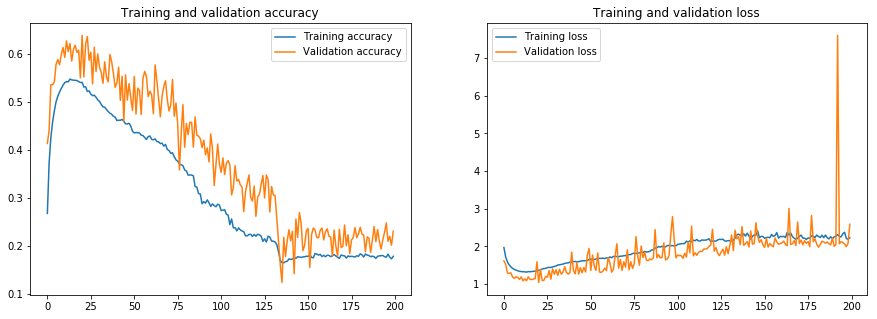

In [3]:
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'9_layers_cifar_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        print(f"For alpha = {alpha}:\n Max test accuracy = {max(history['val_acc']):.04}\n")

    plot_accuracy_and_loss(history)

In [3]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

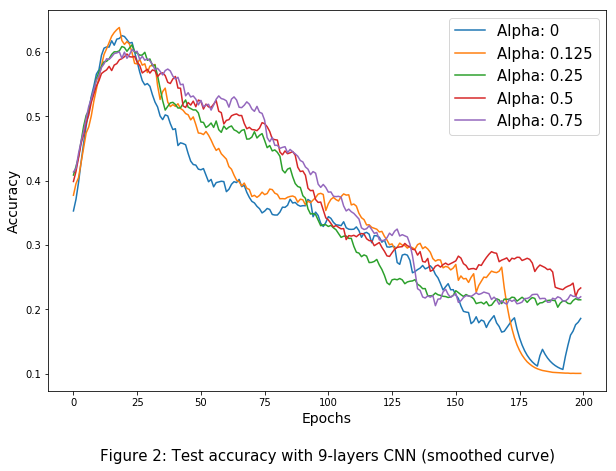

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'9_layers_cifar_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        ax.plot(smooth_curve(history['val_acc']), label=f"Alpha: {alpha}", )

ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title("Figure 2: Test accuracy with 9-layers CNN (smoothed curve)", size=15, y=-0.2)
ax.legend(prop={'size': 15})

plt.show()